В даному ноутбуку вказано учбову реалізацію запропонованої в випускній-кваліфікаційній роботі
україномовної моделі для запрононованої та реалізованої в випускній-кваліфікаційній роботі системи аналізу настроїв у текстових повідомленнях.

Був використаний датасет з нечіткою класифікацією типу позитивний/негативний.
Використано власний розроблений датасет зі розміченими словами українською мовою. Він включає наступні датасети:
https://github.com/skupriienko/Ukrainian-Sentiment-Analysis

Сама система знаходиться в окремому ноутбуці за наступним посиланням
https://colab.research.google.com/drive/1ZmlgVkDFcaf7xYx6UNqIIsH7YCz0MVJs?usp=sharing

# Train your ukranian emotion analysis model here.

**Крок 1: Виконайте наступну клітинку, щоб завантажити усі необхідні бібліотеки.**

In [ ]:
#Інсталяція необхідних бібліотек
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

In [ ]:
#Виконайте цю клітинку, щоб підключити ваш Google Drive для збереження моделі
drive.mount('/content/drive')

Mounted at /content/drive


**Крок #2: Завантаження даних: для тренування, валідації та тестування.**

Даний датасет має 3 файли помічених за наступним принципом:

1.   Колонка "слово" - список слів для датасету
2.   Колонка "pos_neg" - бінарне позначення -1;1 для негативного/позитивного слова у датасеті.

Завантажуемо відповідні дані у відповідні клітинки + призначення відповідних
параметрів до завантаженних даних.
Для коректної роботи маємо наступний порядок:


1.   Тренування - файл має назву "train.csv"
2.   Валідація - файл має назву "val.csv"
3.   Тестування - файл має назву "test.csv"

**ВАЖЛИВО:**

Для успішного тренування подібної учбової моделі, ваші дані повинні бути розмічені за наступною аналогією (без елементів списку):

*   слово/фраза; 0
*   слово/фраза; 1


Перебачається, що ваш датасет буде мати бінарну систему:
0 буде означати "негативний настрій", а 1 - "позитивний настрій".

In [ ]:
# Функція для завантаження файлів датасету згідно набору
from google.colab import files

def upload_data(name):
  uploaded = files.upload()
  if uploaded:
    data_path = list(uploaded.keys())[0]
    df = pd.read_csv(data_path, header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
    return df
  else:
    print(f"No {name} data uploaded.")
    return None

# Upload train, test, and val datasets
print("Завантажте ваш train.csv файл")
df_train = upload_data("train")
print("Завантажте ваш val.csv файл")
df_val = upload_data("val")
print("Завантажте ваш test.csv файл")
df_test = upload_data("test")

# Check if all datasets were uploaded successfully
if df_train is not None and df_test is not None and df_val is not None:
  print("Всі датасети успішно завантажено!")
else:
  print("Одного чи декількох датасетів не вистачає, спробуйте ще раз.")

Завантажте ваш train.csv файл


Saving train.csv to train.csv
Завантажте ваш val.csv файл


Saving val.csv to val.csv
Завантажте ваш test.csv файл


Saving test.csv to test.csv
Всі датасети успішно завантажено!


**Крок №3: Перевірка наявних даних та дізнання кількості унікальних слів**

In [ ]:
X=df_train['Input']
lst=[]
for i in X:
  lst.append(len(i))


In [ ]:
df_train['Sentiment']

0        1
1        0
2        1
3        0
4        1
        ..
15995    0
15996    1
15997    0
15998    1
15999    0
Name: Sentiment, Length: 16000, dtype: int64

In [ ]:
len1=pd.DataFrame(lst)
len1.describe()

0
count  16000.000000
mean       9.001188
std        2.397352
min        2.000000
25%        7.000000
50%        9.000000
75%       10.000000
max       24.000000

**Крок №4: Перевірка наявних даних та підготовка токенайзера для даних**



In [ ]:
# Fit the tokenizer with a reasonable maximum vocabulary size (e.g., 20000)
tokenizer = Tokenizer(num_words=20000, char_level=True, lower=True, oov_token='')
tokenizer.fit_on_texts(X)

In [ ]:
X_train=tokenizer.texts_to_sequences(X)
X_train_pad=pad_sequences(X_train,maxlen=80,padding='post')

In [ ]:
# Convert labels to 0 and 1 (assuming 1 for positive sentiment and 0 for negative sentiment)
Y_train = df_train['Sentiment'].values
Y_train

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
# Prepare the validation data
X_val = df_val['Input']
Y_val = df_val['Sentiment'].values
X_val_f = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_f, maxlen=80, padding='post')

**Крок №5: Побудова RNN LSTM моделі**

In [ ]:
#Import all required libs (as checkup):
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout

In [ ]:
# Cell 7: Build and train the RNN (LSTM) model
# Define the model architecture
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 64, input_length=80))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 64)            2496      
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 71665 (279.94 KB)
Trainable params: 71665 (279.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
history = model.fit(X_train_pad, Y_train, epochs=12, validation_data=(X_val_pad, Y_val), callbacks=[early_stopping])


Epoch 1/12
500/500 [==============================] - 11s 13ms/step - loss: 0.6332 - accuracy: 0.6421 - val_loss: 0.6314 - val_accuracy: 0.6430
Epoch 2/12
500/500 [==============================] - 6s 12ms/step - loss: 0.6042 - accuracy: 0.6663 - val_loss: 0.6099 - val_accuracy: 0.6675
Epoch 3/12
500/500 [==============================] - 5s 10ms/step - loss: 0.5852 - accuracy: 0.6851 - val_loss: 0.5906 - val_accuracy: 0.6830
Epoch 4/12
500/500 [==============================] - 5s 10ms/step - loss: 0.5642 - accuracy: 0.7064 - val_loss: 0.5845 - val_accuracy: 0.6920
Epoch 5/12
500/500 [==============================] - 6s 12ms/step - loss: 0.5446 - accuracy: 0.7262 - val_loss: 0.5594 - val_accuracy: 0.7195
Epoch 6/12
500/500 [==============================] - 5s 9ms/step - loss: 0.5222 - accuracy: 0.7424 - val_loss: 0.5501 - val_accuracy: 0.7260
Epoch 7/12
500/500 [==============================] - 5s 11ms/step - loss: 0.4957 - accuracy: 0.7623 - val_loss: 0.5251 - val_accuracy: 0.7455

**Крок 6: Графічне відображення ефективності тренування**

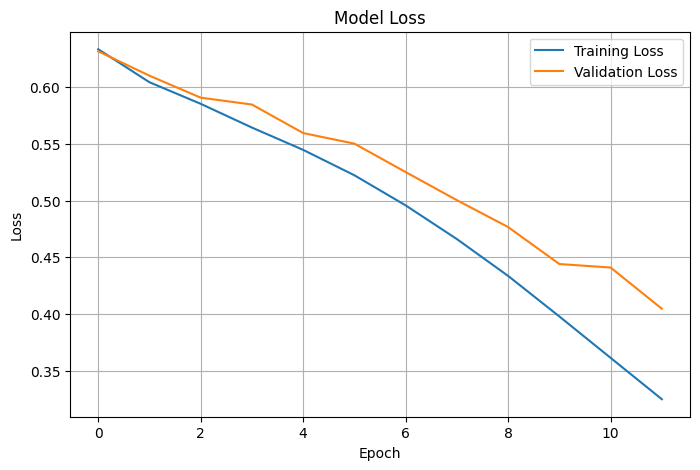

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  """
  Plots the training and validation loss curves from the training history.
  """
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_loss(history)

In [ ]:
#Підготовка датасету для тестування, використвуючи завантажений раніше набір даних
X_test = df_val['Input']
Y_test = df_val['Sentiment'].values
X_test_f = tokenizer.texts_to_sequences(X_test)

X_test_pad=pad_sequences(X_test_f,maxlen=80,padding='post')


In [ ]:
#Evaluate our model on test data before user output:
model.evaluate(X_test_pad,Y_test)

63/63 [==============================] - 1s 8ms/step - loss: 0.4047 - accuracy: 0.8375


[0.40471065044403076, 0.8374999761581421]

**Крок 7: Перевірка розробленої учбової моделі на реальних даних перед збереженням.**

Це опціональний крок, користувач може продовжити використовувати створену модель в самій системі.



In [ ]:
# Cell 8: Test the model with user input
def test_model(model, tokenizer):
    user_input = input("Введіть український текст для передбачення настрою: ")

    # Tokenize user input
    user_sequence = tokenizer.texts_to_sequences([user_input])
    user_padded = pad_sequences(user_sequence, maxlen=80, padding='post')

    # Make prediction
    prediction = model.predict(user_padded)

    # Convert prediction to sentiment label
    if prediction >= 0.5:
        sentiment = "Позитивний"
    else:
        sentiment = "Негативний"

    # Output sentiment
    print("Передбачений настрій:", sentiment)

# Call the test_model function
test_model(model, tokenizer)


Введіть український текст для передбачення настрою: стули свою пельку покидьок
1/1 [==============================] - 0s 21ms/step
Передбачений настрій: Негативний


**ФІНАЛ: Збержіть Вашу модель на Google Drive чи жорсткому диску ПК, вибравши
необхідну клітинку.**
Введіть ім'я Вашої моделі, можна використати звичайне значення.

Збереженна модель має формат .h5 + зберігається токенайзер моделі у форматі .pickle.

Назви обох файлів вводяться у наступні клітинки з текстовими полями.

In [ ]:
model_name = "rnn_ua" # @param {type:"string"}


In [ ]:
tokenizer_name = "rnn_ua" # @param {type:"string"}


In [ ]:
#Using next function to save our data to our Google Drive.
import pickle
def save_model_and_tokenizer(model, tokenizer, model_name, tokenizer_name):
  """
  Saves the model and tokenizer to user's Google Drive.
  """
  model_path = f'/content/drive/MyDrive/emot-sys/models/{model_name}.h5'
  tokenizer_path = f'/content/drive/MyDrive/emot-sys/tokenizers/{tokenizer_name}.pickle'

  # Save model
  model.save(model_path)
  print(f"Model saved to: {model_path}")

  # Save tokenizer
  with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
  print(f"Tokenizer saved to: {tokenizer_path}")

# Saving usage:
save_model_and_tokenizer(model, tokenizer, model_name, tokenizer_name)

Model saved to: /content/drive/MyDrive/emot-sys/models/rnn_ua.h5
Tokenizer saved to: /content/drive/MyDrive/emot-sys/tokenizers/rnn_ua.pickle


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
